# Matthew Sinnott: Final Project

This file contains both the code that I used to test various models, code to reshape and regularize the datasets and the final code. My project is using a merged dataset, (both cars and signs), so I first have individual sign and car prediction models to get a feeling for each individual dataset and then another set of models to classify between them both.

## Imports

Nothing much to see here...

In [2]:
import os
from shutil import copyfile
from random import randint

from heapq import nlargest
from PIL import Image, ImageFile
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
from imageio import imread
from sklearn.datasets import load_files
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation, Lambda
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras import applications 
from keras import backend as kb
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Signs Processing

There were not any publicly accesible datasets for US road signs but there are multiple European ones. I am using a Belgian dataset - while some of the signs are different, others, like the stop sign, are the same as ones in the US. This is an interesting dataset becuase of its bias towards certain signs as opposed to others; the number of examples per section varies from less than 10 to more than 400 for others. Therefore, data augmentation to even out the train data is a must. Interestingly, some of the images are repeated, but not augmented: there are multiple pictures of the same sign but from different angles and at different distances, acting as "real-life data augmentation." There is also a German signs dataset, but it is far smaller and consists almost entirely of repeated shots of the same sign (it looks like they were pulled from a video of a car driving by the sign), so I decided not to use it. Links to all the dataset are in the README.

In [12]:
# Just some filepaths
signs_train_data_dir = 'signs/traffic_signs_train'
signs_test_data_dir ='signs/traffic_signs_test'

signs_train_features_file = 'signs/features_signs_train.npy'
signs_test_features_file = 'signs/features_signs_test.npy'

transfer_signs_weights_path = 'signs/transfer_weights.h5'
custom_signs_weights_path = 'signs/custom_weights.h5'

nb_train_samples = 4575
nb_test_samples = 2529

epochs = 50
batch_size = 50

In [3]:
# Example data generator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1.0/255,
        horizontal_flip=True,
        fill_mode='nearest')

aug_generator = datagen.flow_from_directory(signs_train_data_dir, target_size=(256, 256), 
                                         batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 4575 images belonging to 62 classes.


In [4]:
arr = aug_generator.next()

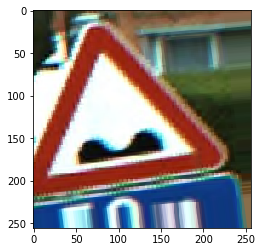

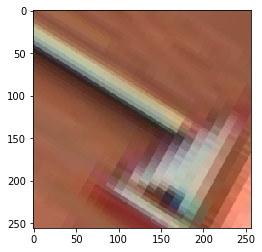

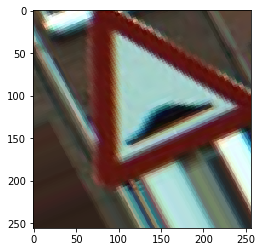

In [5]:
ind = [randint(0, x-1) for x in [len(arr[0])] * 3]

for i in ind:
    plt.imshow(arr[0][i], interpolation='nearest')
    plt.show()

### Transfer Learning

In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1.0/255,
        horizontal_flip=True,
        fill_mode='nearest')

# build the inception network
inc_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

train_generator = datagen.flow_from_directory(signs_train_data_dir, target_size=(256, 256), batch_size=batch_size, 
                                         class_mode='categorical', shuffle=False)
train_data = inc_model.predict_generator(train_generator)
np.save(open(signs_train_features_file, 'wb'), train_data)


test_generator = datagen.flow_from_directory(signs_test_data_dir, target_size=(256, 256), batch_size=batch_size, 
                                         class_mode='categorical', shuffle=False)
test_data = inc_model.predict_generator(test_generator)
np.save(open(signs_test_features_file, 'wb'), test_data)
    
train_labels = train_generator.classes
test_labels = test_generator.classes

Found 4575 images belonging to 62 classes.
Found 2529 images belonging to 62 classes.


In [7]:
# One-hot encoding
label_encoder = OneHotEncoder()
train_labels_enc = label_encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_enc = label_encoder.fit_transform(test_labels.reshape(-1,1))

print(train_labels.shape)
print(test_labels.shape)

print(train_labels_enc.shape)
print(test_labels_enc.shape)

(4575,)
(2529,)
(4575, 62)
(2529, 62)


In [8]:
train_data = np.load(open(signs_train_features_file, 'rb'))
print(train_data.shape)
        
test_data = np.load(open(signs_test_features_file, 'rb'))
print(test_data.shape)

(4575, 6, 6, 2048)
(2529, 6, 6, 2048)


In [16]:
# the top model:
#  BatchNormalization to try to even out differences and stabilize training
#  Droupout to prevent overfitting
#  3 Dense layers to conbine the outputs

model = Sequential()    
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(62, activation='softmax'))

model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
model.fit(train_data, train_labels_enc,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_data, test_labels_enc))

Train on 4575 samples, validate on 2529 samples
Epoch 1/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0750 - categorical_accuracy: 0.9784 - val_loss: 1.6000 - val_categorical_accuracy: 0.7509
Epoch 2/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0704 - categorical_accuracy: 0.9781 - val_loss: 1.7523 - val_categorical_accuracy: 0.7529
Epoch 3/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0586 - categorical_accuracy: 0.9792 - val_loss: 1.4361 - val_categorical_accuracy: 0.7631
Epoch 4/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0553 - categorical_accuracy: 0.9827 - val_loss: 1.3729 - val_categorical_accuracy: 0.7750
Epoch 5/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0483 - categorical_accuracy: 0.9854 - val_loss: 1.4909 - val_categorical_accuracy: 0.7537
Epoch 6/50
4575/4575 [==============================] - 8s 2ms/step - loss: 0.0513 - categorical_accuracy: 0.985

In [18]:
model.save_weights(transfer_signs_weights_path)

### Custom Model

In [19]:
train_datagen = ImageDataGenerator(
           rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Custom model:
#  4 convolution layers, each followed by a maxpool
#  2 dense layers to train on the output of the filters

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))
        
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()
        
train_generator = train_datagen.flow_from_directory(
            signs_train_data_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
            signs_test_data_dir,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='categorical')

model.fit_generator(train_generator,
            epochs=100,
            validation_data=test_generator)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 15, 15, 64)        36928     
__________

Epoch 47/100
92/92 [==============================] - 36s 392ms/step - loss: 0.1562 - acc: 0.9535 - val_loss: 0.1383 - val_acc: 0.9676
Epoch 48/100
92/92 [==============================] - 36s 391ms/step - loss: 0.1707 - acc: 0.9504 - val_loss: 0.1359 - val_acc: 0.9715
Epoch 49/100
92/92 [==============================] - 36s 393ms/step - loss: 0.1759 - acc: 0.9515 - val_loss: 0.1428 - val_acc: 0.9692
Epoch 50/100
92/92 [==============================] - 36s 390ms/step - loss: 0.1704 - acc: 0.9500 - val_loss: 0.1165 - val_acc: 0.9739
Epoch 51/100
92/92 [==============================] - 36s 392ms/step - loss: 0.1734 - acc: 0.9515 - val_loss: 0.1042 - val_acc: 0.9802
Epoch 52/100
92/92 [==============================] - 36s 392ms/step - loss: 0.1651 - acc: 0.9578 - val_loss: 0.1767 - val_acc: 0.9644
Epoch 53/100
92/92 [==============================] - 36s 391ms/step - loss: 0.1696 - acc: 0.9522 - val_loss: 0.1728 - val_acc: 0.9727
Epoch 54/100
92/92 [==============================] - 3

In [20]:
model.save_weights(custom_signs_weights_path)

## Stanford Car Database
This dataset was interesting because it was just 2 folders - one with 16k images (the whole dataset), and then the specific train dataset with 8k and then mat files for each of them. Interestingly, the test dataset was unlabeled, so I only had 8k images to work with.
I needed to write code to convert that into the format that Keras expects, with subdirectories for each class so that the directoy flows would work

In [3]:
train_directory  = 'cars/cars_train'
train_mat_file = 'cars/devkit/cars_train_annos.mat'

main_mat_file = 'cars/cars_annos.mat'

cars_train_features_file = 'cars/features_cars_train.npy'
cars_train_labels_file = 'cars/labels_cars_train.npy'

transfer_car_weights_path = 'cars/transfer_weights.npy'
custom_car_weights_path  = 'cars/custom_weights.npy'

epochs = 200
batch_size = 32

train_mat = scipy.io.loadmat(train_mat_file)
main_mat = scipy.io.loadmat(main_mat_file)

In [22]:
class_arrs = main_mat['class_names'][0]
classes = [x[0] for x in class_arrs]
print('Loaded Class Names')

train_labels = [x[4][0][0]-1 for x in train_mat['annotations'][0]]
print('Loaded Training Labels')

label_encoder = OneHotEncoder()
train_labels_enc = label_encoder.fit_transform(np.array(train_labels).reshape(-1,1))

Loaded Class Names
Loaded Training Labels


In [23]:
## takes the directory of junk and makes it the standard subdirectory structure by class
def rebuild_directory_structure():
    for car in train_mat['annotations'][0]:
        car_class = car[4][0][0]
        car_file = car[5][0]
        
        if not os.path.exists(train_directory + "/" + str(car_class)):
            os.mkdir(train_directory + "/" + str(car_class))
    
        copyfile(train_directory + "/" + car_file, train_directory + "/" + str(car_class) + "/" + car_file)

In [27]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        rescale=1.0/255,
        horizontal_flip=True,
        fill_mode='nearest')

generator = datagen.flow_from_directory(train_directory, 
                                        batch_size=10, target_size=(299,299), shuffle=False)

Found 8144 images belonging to 196 classes.


In [28]:
arr = generator.next()

[  0   0   0 ... 195 195 195]
815
10


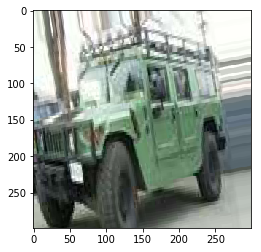

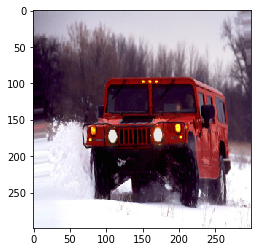

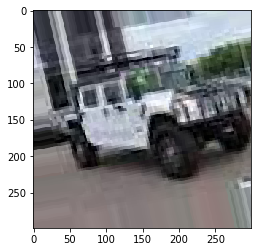

In [29]:
print(generator.classes)
print(len(generator))
print(len(arr[0]))

ind = [randint(0, x-1) for x in [len(arr[0])] * 3]

for i in ind:
    plt.imshow(arr[0][i], interpolation='nearest')
    plt.show()

### Transfer Learning

In [ ]:
model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')

bottleneck_features_train = model.predict_generator(generator)
np.save(open(cars_train_features_file, 'wb'), bottleneck_features_train)

train_data_labels = generator.classes;

label_file = open(cars_train_labels_file, 'w')
for line in train_data_labels:
    label_file.write(str(line) + '\n')

In [4]:
train_data = np.load(open(cars_train_features_file, 'rb'))

label_file = open(cars_train_labels_file, 'r')
train_data_labels = np.array([int(line.replace('\n', '')) for line in label_file])

label_encoder = OneHotEncoder()
train_data_labels_enc = label_encoder.fit_transform(train_data_labels.reshape(-1,1))

In [5]:
# To preserve labels when doing the transfer learning we need to use a non-shuffled generator and then shuffle with a train-test split
train_vals, test_vals, train_labels, test_labels = train_test_split(train_data, train_data_labels_enc,
                                                                    test_size=0.33, random_state=42)

The top model is simple - just a couple of Dense layers attached to a final convolutional layer. I'm using top five categorical accuracy because of the difficulty in distinguishing between different models of the same car. 

In [6]:
model = Sequential()    
model.add(Conv2D(128, (5,5), input_shape=train_vals[1].shape))
model.add(GlobalMaxPooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(196, activation='softmax'))

def top_5_accuracy(x,y):
    return top_k_categorical_accuracy(x, y, k=5)

model.compile(optimizer='nadam',
                    loss='categorical_crossentropy', metrics=[top_5_accuracy])

model.fit(train_vals, train_labels,
              validation_data=(test_vals, test_labels),
              epochs=10,
              batch_size=batch_size)

Train on 5456 samples, validate on 2688 samples
Epoch 1/10
5456/5456 [==============================] - 76s 14ms/step - loss: 15.9737 - top_5_accuracy: 0.9776 - val_loss: 16.0401 - val_top_5_accuracy: 1.0000
Epoch 2/10
5456/5456 [==============================] - 53s 10ms/step - loss: 16.0265 - top_5_accuracy: 1.0000 - val_loss: 16.0401 - val_top_5_accuracy: 1.0000
Epoch 3/10
5456/5456 [==============================] - 53s 10ms/step - loss: 16.0265 - top_5_accuracy: 1.0000 - val_loss: 16.0401 - val_top_5_accuracy: 1.0000
Epoch 4/10
5456/5456 [==============================] - 53s 10ms/step - loss: 16.0265 - top_5_accuracy: 1.0000 - val_loss: 16.0401 - val_top_5_accuracy: 1.0000
Epoch 5/10
5456/5456 [==============================] - 53s 10ms/step - loss: 16.0265 - top_5_accuracy: 1.0000 - val_loss: 16.0401 - val_top_5_accuracy: 1.0000
Epoch 6/10
5456/5456 [==============================] - 53s 10ms/step - loss: 16.0265 - top_5_accuracy: 1.0000 - val_loss: 16.0401 - val_top_5_accuracy:

In [7]:
model.save_weights(transfer_car_weights_path)

### Custom Model

For the sake of completeness I wanted to run a custom model on the data. However, due to its slow training time and poor performance, I will not be using it for the final model.

In [9]:
train_datagen = ImageDataGenerator(
           rescale=1./255,
         #   shear_range=0.2,
           # zoom_range=0.2,
            horizontal_flip=True)
    
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(196, activation='softmax'))
        
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=[top_5_accuracy])

model.summary()
        
train_generator = train_datagen.flow_from_directory(
            train_directory,
            target_size=(150, 150),
            batch_size=128,
            class_mode='categorical')

model.fit_generator(train_generator,
            epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 32)        16416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 64)          36928     
__________

## Final Model

I am using a transfer learning model for the merged dataset due to its better performance on the cars subdataset. Due to the large size of the dataset, I train with the whole model in one shot to ensure that everything can fit in memory. It takes _forever_, but it works and doesn't throw an out-of-memory error, so that's what we're doing. It should eventually get to a reasonable (>70%) accuracy, but I don't have time to run it so I ran it for ~30 epochs and got it to be about 50% accurate.

In [2]:
merged_train_directory  = 'merged/data'
model_weights_path  = 'merged/model_weights.npy'

merged_features_file = 'merged/features_merged.npy'
merged_labels_file = 'merged/labels_merged.npy'

epochs = 5
batch_size =32

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1.0/255,
        fill_mode='nearest')

base_model = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [5]:
generator = datagen.flow_from_directory(merged_train_directory, target_size=(299,299), 
                                        batch_size=batch_size, shuffle=True)

Found 12719 images belonging to 258 classes.


In [4]:
top_model = base_model.output
top_model = GlobalAveragePooling2D(input_shape=base_model.output_shape)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(258, activation='softmax')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)
               
def top_5_accuracy(x,y):
    return top_k_categorical_accuracy(x, y, k=5)

model.compile(optimizer='nadam',
                    loss='categorical_crossentropy', metrics=[top_5_accuracy])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [58]:
model.fit_generator(generator,
              epochs=1)
model.save_weights(model_weights_path)

Epoch 1/1
398/398 [==============================] - 1340s 3s/step - loss: 3.0861 - top_5_accuracy: 0.4896


Found 12719 images belonging to 258 classes.


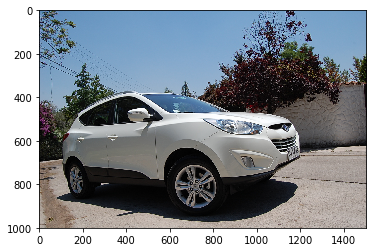

['62', '132', '166', '174', '110']


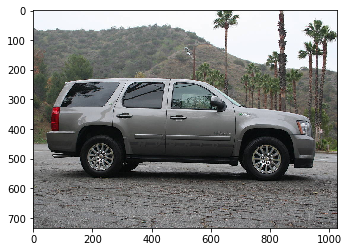

['00054', '00056', '85', '00022', '62']


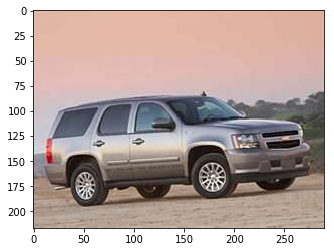

['169', '132', '174', '178', '00032']
--------------


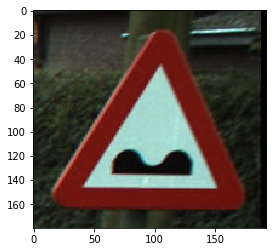

['00032', '00000', '00001', '00002', '00003']


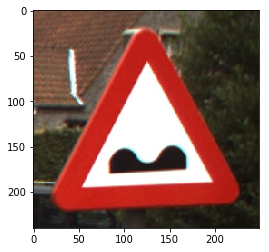

['00041', '00038', '00040', '00000', '00001']


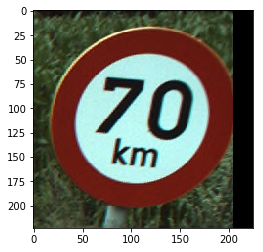

['00047', '00032', '00041', '00058', '146']


In [5]:
model.load_weights(model_weights_path)

sample_datagen = ImageDataGenerator(rescale=1.0/255)

sample_generator = datagen.flow_from_directory(merged_train_directory, target_size=(299,299), 
                                        batch_size=batch_size, shuffle=True)

label_lookup = {v: k for k,v in sample_generator.class_indices.items()}

def process_image(path):
    img = imread(path)
    plt.imshow(img, interpolation='nearest')
    plt.show()

    def predict_image(img):
        res = model.predict(np.expand_dims(img, axis=0))
        return nlargest(5, range(len(res[0])), res[0].take)

    return [label_lookup[x] for x in predict_image(img)]

images = ["merged/data/132/00234.jpg", "merged/data/62/02319.jpg",
          "merged/data/62/02354.jpg"]

for im in images:
    print(process_image(im))
    
    
print("--------------")    
images = ["merged/data/00000/01797_00001.ppm", "merged/data/00000/01798_00001.ppm",
          "merged/data/00032/00018_00000.ppm", ]

for im in images:
    print(process_image(im))